# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,low_risk,n,9.60,...,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0,N,N
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-2019,low_risk,n,29.07,...,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0,N,N
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-2019,low_risk,n,14.86,...,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0,N,N
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-2019,low_risk,n,9.96,...,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0,N,N


In [5]:
# Checking categorical data
df_cat = df.select_dtypes(exclude=[np.number])
pd.Series((df[col].unique() for col in df_cat.columns),index=df_cat.columns)

home_ownership                         [RENT, MORTGAGE, OWN, ANY]
verification_status     [Source Verified, Verified, Not Verified]
issue_d                            [Mar-2019, Feb-2019, Jan-2019]
loan_status                                 [low_risk, high_risk]
pymnt_plan                                                    [n]
initial_list_status                                        [w, f]
next_pymnt_d                                 [May-2019, Apr-2019]
application_type                          [Individual, Joint App]
hardship_flag                                                 [N]
debt_settlement_flag                                          [N]
dtype: object

In [6]:
# Encoding categorical data except target
df_encoded = pd.get_dummies(df, columns= df_cat.drop(columns="loan_status").columns)
df_encoded

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,low_risk,9.60,0.0,0.0,9.0,0.0,...,0,1,0,1,0,1,1,0,1,1
68813,12000.0,0.2727,368.37,63000.0,low_risk,29.07,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,1,1
68814,5000.0,0.1992,185.62,52000.0,low_risk,14.86,0.0,0.0,5.0,1.0,...,0,1,0,1,0,1,1,0,1,1
68815,40000.0,0.0646,1225.24,520000.0,low_risk,9.96,0.0,1.0,21.0,0.0,...,0,1,1,0,0,1,1,0,1,1


# Split the Data into Training and Testing

In [7]:
# Create our features
X = df_encoded.drop(columns="loan_status")

# Create our target
y = df_encoded["loan_status"]

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [11]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

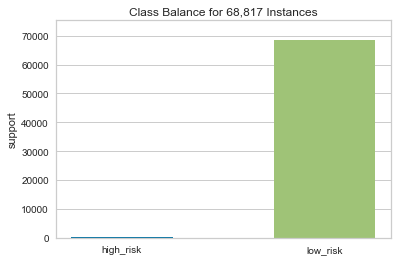

In [12]:
# Visualize distribution of y
from yellowbrick.target import ClassBalance

viz = ClassBalance()
viz.fit(y)
viz.show()       

In [13]:
# Create X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
print (f"Train data: {Counter(y_train)}"), print (f"Test Data: {Counter(y_test)}")

Train data: Counter({'low_risk': 51366, 'high_risk': 246})
Test Data: Counter({'low_risk': 17104, 'high_risk': 101})


(None, None)

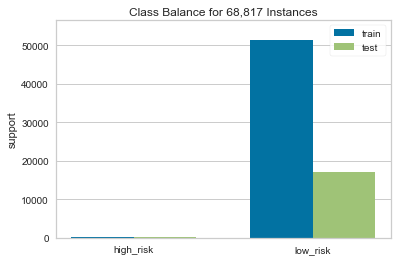

In [15]:
# Visualize train and test y
viz = ClassBalance()

viz.fit(y_train,y_test)
viz.show()

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [16]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print (f"Train data: {Counter(y_resampled)}"), print (f"Test Data: {Counter(y_test)}")

Train data: Counter({'low_risk': 51366, 'high_risk': 51366})
Test Data: Counter({'low_risk': 17104, 'high_risk': 101})


(None, None)

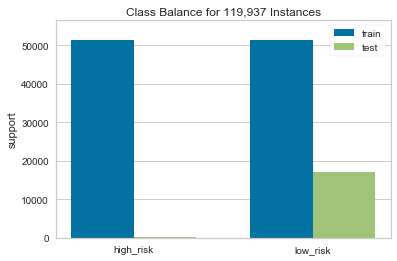

In [17]:
# Visualize resampled train and test y
viz = ClassBalance()
viz.fit(y_resampled,y_test)
viz.show()

In [18]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression

model_ROS = LogisticRegression(random_state=1)
model_ROS.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# Predict using out-of-sample data
y_pred = model_ROS.predict(X_test)

In [20]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.7163908158823367

In [21]:
# Display the confusion matrix
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[   73,    28],
       [ 4960, 12144]])

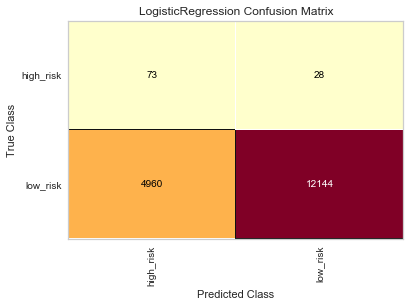

In [22]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_ROS)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [23]:
# Print the imbalanced classification report
# YOUR CODE HERE
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.72      0.71      0.03      0.72      0.51       101
   low_risk       1.00      0.71      0.72      0.83      0.72      0.51     17104

avg / total       0.99      0.71      0.72      0.82      0.72      0.51     17205



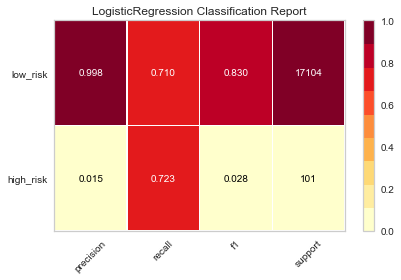

In [24]:
# Visualize imbalanced classification report
from yellowbrick.classifier import ClassificationReport

viz = ClassificationReport(model_ROS, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

### SMOTE Oversampling

In [25]:
# Resample the training data with SMOTE
# YOUR CODE HERE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, ratio=1.0).fit_resample(
    X_train, y_train
)

Counter(y_resampled),  Counter(y_test)

(Counter({'low_risk': 51366, 'high_risk': 51366}),
 Counter({'low_risk': 17104, 'high_risk': 101}))

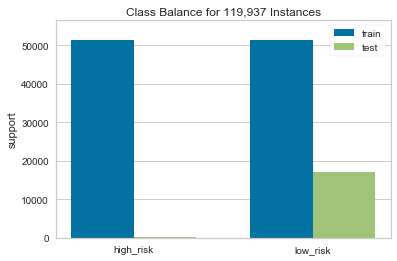

In [26]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [27]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model_SMOTE = LogisticRegression(random_state=1)
model_SMOTE.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Predict using out-of-sample data
y_pred = model_SMOTE.predict(X_test)

In [29]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)

0.7001170474858525

In [30]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)

array([[   71,    30],
       [ 5178, 11926]])

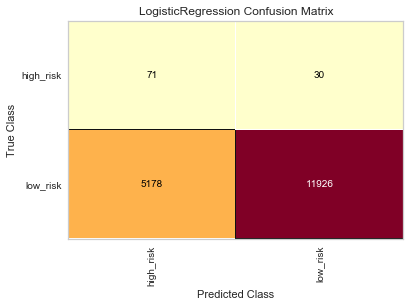

In [31]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_SMOTE)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [32]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.70      0.70      0.03      0.70      0.49       101
   low_risk       1.00      0.70      0.70      0.82      0.70      0.49     17104

avg / total       0.99      0.70      0.70      0.82      0.70      0.49     17205



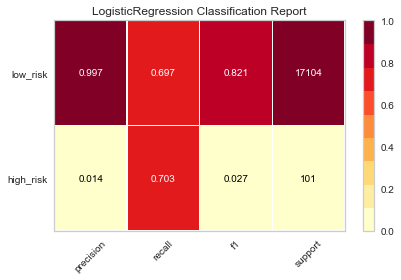

In [33]:
# Visualize imbalanced classification report 
viz = ClassificationReport(model_SMOTE, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [34]:
# Resample the data using the ClusterCentroids resampler
# YOUR CODE HERE
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

Counter(y_resampled), Counter(y_test)

(Counter({'high_risk': 246, 'low_risk': 246}),
 Counter({'low_risk': 17104, 'high_risk': 101}))

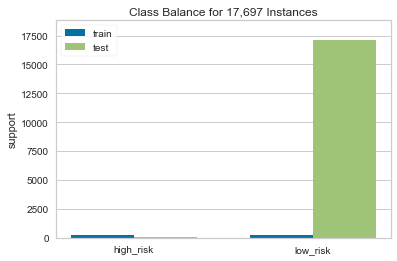

In [35]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [36]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model_CC = LogisticRegression(random_state=1)
model_CC.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# Predict using out-of-sample data
y_pred = model_CC.predict(X_test)

In [38]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)

0.6433412021043078

In [39]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)

array([[  82,   19],
       [8983, 8121]])

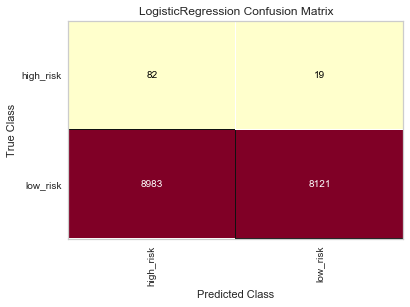

In [40]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_CC)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [41]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.81      0.47      0.02      0.62      0.40       101
   low_risk       1.00      0.47      0.81      0.64      0.62      0.37     17104

avg / total       0.99      0.48      0.81      0.64      0.62      0.37     17205



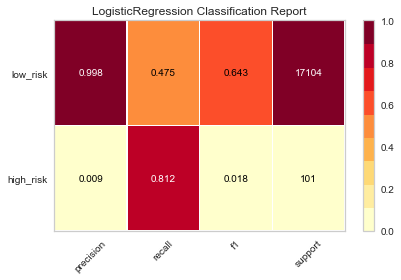

In [42]:
# Visualize imbalanced classification report
viz = ClassificationReport(model_CC, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [43]:
# Resample the training data with SMOTEENN
# YOUR CODE HERE
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print (f"Re-sampled train data: {Counter(y_resampled)}"), print (f"Test data: {Counter(y_test)}")

Re-sampled train data: Counter({'high_risk': 51361, 'low_risk': 46653})
Test data: Counter({'low_risk': 17104, 'high_risk': 101})


(None, None)

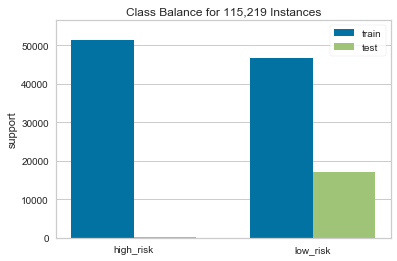

In [44]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [45]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model_SMOTEEN = LogisticRegression(random_state=1)
model_SMOTEEN.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
# Predict using out-of-sample data
y_pred = model_SMOTEEN.predict(X_test)

In [47]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)

0.69732081662329

In [48]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)

array([[   72,    29],
       [ 5443, 11661]])

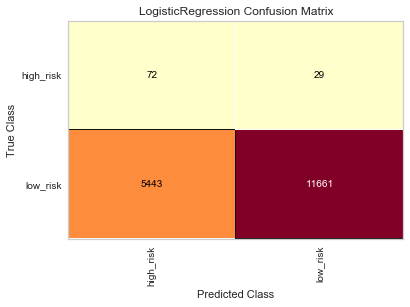

In [49]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_SMOTEEN)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [50]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.71      0.68      0.03      0.70      0.49       101
   low_risk       1.00      0.68      0.71      0.81      0.70      0.48     17104

avg / total       0.99      0.68      0.71      0.81      0.70      0.48     17205



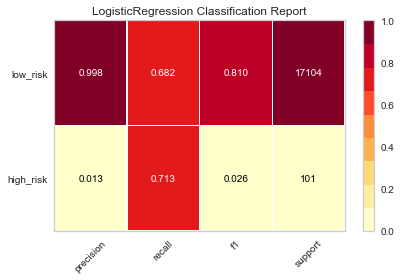

In [51]:
# Visualize imbalanced classification report 
viz = ClassificationReport(model_SMOTEEN, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()